In [2]:
Forecasting Stock Prices using XGBoost (Part 1/2) : 
    https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a
Forecasting Stock Prices using XGBoost (Part 2/2) :
    https://medium.com/ai-trading-labs/forecasting-stock-prices-using-xgboost-part-2-2-5fa8ce843690

https://www.machinelearningmastery.ru/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a/
https://github.com/NGYB/Stocks

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor


In [2]:
def invboxcox(y,lmbda):# обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

def get_mape(y_true, y_pred): 
    """
    Вычислить среднюю абсолютную процентную ошибку (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std cv
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std cv
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

In [3]:
def train_pred_xgboost(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        mape               : mean absolute percentage error of y_test and pred
        rmse               : root mean square error of y_test and pred
        r2                 : r2
        pred               : predicted values. Same length as y_test
    '''
                            #seed=model_seed
    model = XGBRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    pred_scaled = model.predict(X_test_scaled)
    pred = pred_scaled * col_std + col_mean

    # Calculate error
    mape = get_mape(y_test, pred)
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    
    return  mape, rmse, r2, pred

# Загрузка данных 

In [4]:
# загрузка dataset
db = pd.read_csv('SalesX.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False) #1,045,311

In [98]:
df2 = db
df2.info()
df2

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1045311 entries, 2015-08-30 13:17:00 to 2016-06-11 11:52:00
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   ID        1045311 non-null  object 
 1   Category  1045311 non-null  object 
 2   Brand     1045311 non-null  object 
 3   GMV       1045311 non-null  float64
 4   MRP       1045311 non-null  int64  
 5   Units     1045311 non-null  int64  
 6   SLA       1045311 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 63.8+ MB


,ID,Category,Brand,GMV,MRP,Units,SLA
Date,,,,,,,
2015-08-30 13:17:00,ACCE7U2GBCJKQZZV,CameraAccessory,Lens,285.0,395,1,16
2015-09-14 16:06:00,AUDEAFDA5GGESPWX,EntertainmentSmall,AudioMP3Player,299.0,999,1,8
2015-09-15 13:06:00,ACCDH7MFZJGRWJCW,GamingHardware,GamePad,284.0,410,1,5
2015-09-22 11:26:00,VGLE7AUXCYJWGBRV,EntertainmentSmall,VideoGlasses,419.0,349,1,9
2015-09-22 17:17:00,REME69QDWFWZGUMB,EntertainmentSmall,RemoteControl,490.0,999,1,8
...,...,...,...,...,...,...,...
2016-05-28 22:27:00,HTHEEDSFSPX3CUHK,EntertainmentSmall,HomeTheatre,2149.0,5999,1,6
2016-05-30 17:51:00,ACCEACG4KY7EAFHR,EntertainmentSmall,LaptopSpeaker,348.0,999,1,4
2016-05-30 17:51:00,ACCE5FQEJWG7TCB4,GamingHardware,GamingAccessoryKit,199.0,599,1,1


Text(0, 0.5, 'usd')

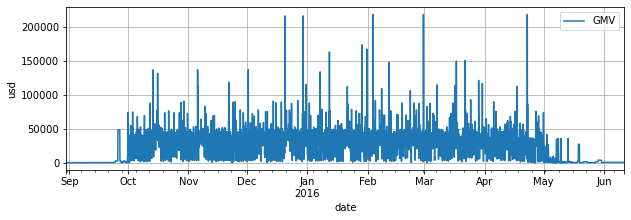

In [99]:
df = df2['GMV'].resample('h').max() #last() first() min() max() mean()
df = df.fillna(method='ffill')
#df = df.dropna()
df.plot(figsize=(10,3),label="GMV", grid = True)
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("usd")

In [101]:
df = df2[['GMV','MRP','SLA','Units']].resample('h').max()
df = df.fillna(method='ffill')

In [102]:
df = pd.DataFrame({'GMV': df.GMV/10,'MRP': df.MRP/10,
                   'SLA': df.SLA,'Units': df.Units
                   })

count     6863.000000
mean      2516.652557
std       1979.410563
min         12.900000
25%        285.000000
50%       3049.000000
75%       3663.900000
max      21850.000000
Name: GMV, dtype: float64
V = 0.786525


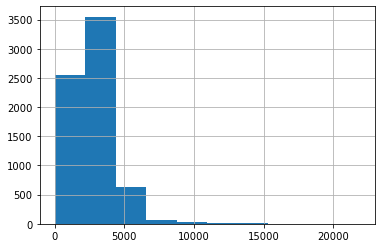

In [103]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df.GMV.hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [104]:
j = 0
l = []
for i in range(0, 6863):
    if df.GMV[i] > 8000:
        df.replace(df.GMV[i], np.nan, inplace=True)
        df.fillna(method='ffill',inplace=True )
        #df.replace(df.GMV[i], df.GMV[i]*100, inplace=True)
        j+=1
        l.append(i)
#df = df.dropna()

count    6863.000000
mean     2452.123386
std      1764.706038
min        12.900000
25%       285.000000
50%      3030.000000
75%      3650.000000
max      7899.900000
Name: GMV, dtype: float64
V = 0.719664


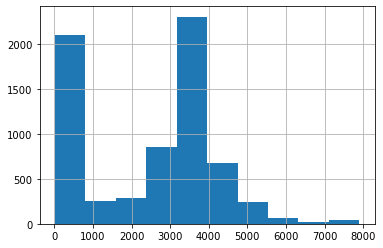

In [105]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df.GMV.hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

Оптимальный параметр преобразования Бокса-Кокса: 0.521195
Критерий Дики-Фуллера: p=0.026532 < 0.05


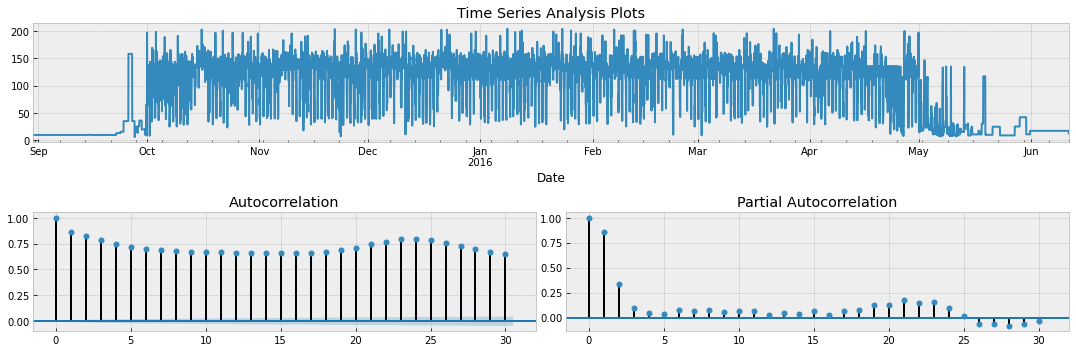

In [106]:
from statsmodels.iolib.table import SimpleTable
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(15, 5), style='bmh'): # Критерий Дики-Фуллера
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1],'< 0.05')

    return 
df['GMV_'] = df.GMV
df['GMV'], lmbda = scs.boxcox(df.GMV)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
tsplot(df.GMV, lags=30)
#df.drop(['GMV1'], axis=1, inplace=True)

# Преобразование набора данных для XGBOOST 

In [107]:
# добавление доп. признаков 
# Convert Date column to datetime
#df.loc[:, 'DATE'] = pd.to_datetime(df['DATE'],format='%d.%m.%Y')

# Change all column headings to be lower case, and remove spacing
#df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
#df["month"] = df['DATE'].dt.month

#df["day"] = df['DATE'].index.day
#df["weekday"] = df.index.weekday
#df['is_weekend'] = df.weekday.isin([5,6])*1
#df["month"] = df.index.month
#df["year"] = df.index.year-2009

df["DATE"] = df.index.date
# Вычислим разницу между
df['range_mg'] = df.MRP - df.GMV_ 
#df.drop(['Units'], axis=1, inplace=True)
df.head()

,GMV,MRP,SLA,Units,GMV_,DATE,range_mg
Date,,,,,,,
2015-08-30 13:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 14:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 15:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 16:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 17:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0


In [108]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['GMV', 'MRP', 'range_mg', 'SLA', 'Units']
lag_cols

['GMV', 'MRP', 'range_mg', 'SLA', 'Units']

In [109]:
N = 3

shift_range = [x+1 for x in range(N)]

for shift in tqdm(shift_range):
    
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
df

100%|██████████| 3/3 [00:00<00:00, 56.49it/s]


,GMV,MRP,SLA,Units,GMV_,DATE,range_mg,order_day,GMV_lag_1,MRP_lag_1,...,GMV_lag_2,MRP_lag_2,range_mg_lag_2,SLA_lag_2,Units_lag_2,GMV_lag_3,MRP_lag_3,range_mg_lag_3,SLA_lag_3,Units_lag_3
3,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,3,9.077921,39.5,...,9.077921,39.5,11.0,16.0,1.0,9.077921,39.5,11.0,16.0,1.0
4,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,4,9.077921,39.5,...,9.077921,39.5,11.0,16.0,1.0,9.077921,39.5,11.0,16.0,1.0
5,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,5,9.077921,39.5,...,9.077921,39.5,11.0,16.0,1.0,9.077921,39.5,11.0,16.0,1.0
6,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,6,9.077921,39.5,...,9.077921,39.5,11.0,16.0,1.0,9.077921,39.5,11.0,16.0,1.0
7,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,7,9.077921,39.5,...,9.077921,39.5,11.0,16.0,1.0,9.077921,39.5,11.0,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,16.653395,129.9,9.0,1.0,77.9,2016-06-11,52.0,6858,16.653395,129.9,...,16.653395,129.9,52.0,9.0,1.0,16.653395,129.9,52.0,9.0,1.0
6859,16.653395,129.9,9.0,1.0,77.9,2016-06-11,52.0,6859,16.653395,129.9,...,16.653395,129.9,52.0,9.0,1.0,16.653395,129.9,52.0,9.0,1.0
6860,16.653395,129.9,9.0,1.0,77.9,2016-06-11,52.0,6860,16.653395,129.9,...,16.653395,129.9,52.0,9.0,1.0,16.653395,129.9,52.0,9.0,1.0
6861,16.653395,129.9,9.0,1.0,77.9,2016-06-11,52.0,6861,16.653395,129.9,...,16.653395,129.9,52.0,9.0,1.0,16.653395,129.9,52.0,9.0,1.0


In [80]:
#df.info()

# Получить среднее и стандартное отклонение на отметке времени t, используя значения из t-1, ..., t-N

In [110]:
cols_list =  ['GMV', 'MRP', 'range_mg', 'SLA', 'Units']

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
    
df.head()

,GMV,MRP,SLA,Units,GMV_,DATE,range_mg,order_day,GMV_lag_1,MRP_lag_1,...,GMV_mean,GMV_std,MRP_mean,MRP_std,range_mg_mean,range_mg_std,SLA_mean,SLA_std,Units_mean,Units_std
3,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,3,9.077921,39.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,4,9.077921,39.5,...,9.077921,NaN,39.5,NaN,11.0,NaN,16.0,NaN,1.0,NaN
5,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,5,9.077921,39.5,...,9.077921,0.0,39.5,0.0,11.0,0.0,16.0,0.0,1.0,0.0
6,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,6,9.077921,39.5,...,9.077921,0.0,39.5,0.0,11.0,0.0,16.0,0.0,1.0,0.0
7,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0,7,9.077921,39.5,...,9.077921,0.0,39.5,0.0,11.0,0.0,16.0,0.0,1.0,0.0


In [79]:
#df.describe()

# Разделить на test, cv и test набор

In [119]:
# Количество train, cv, test наборов данных

test_size = 0.3                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set


n_cv, n_test  = int(cv_size*len(df)), int(test_size*len(df))
n_train = len(df) - n_cv - n_test
print('Количество:')
print(" n_train = " + str(n_train),
        "\n n_cv = " + str(n_cv), 
        "\n n_test = " + str(n_test))


# Разделить на train, cv, and test
train = df[:n_train].copy()
cv = df[n_train:n_train+n_cv].copy()
train_cv = df[:n_train+n_cv].copy()
test = df[n_train+n_cv:].copy()

print(" train = " + str(train.shape),
        "\n cv = " + str(cv.shape), "~ train_cv = " + str(train_cv.shape),
        "\n test = " + str(test.shape))

Количество:
 n_train = 3430 
 n_cv = 1372 
 n_test = 2058
 train = (3430, 33) 
 cv = (1372, 33) ~ train_cv = (4802, 33) 
 test = (2058, 33)


In [120]:
cols_to_scale = [ "GMV" ]

for i in range(1,N+1):
    cols_to_scale.append("GMV_lag_"+str(i))
    cols_to_scale.append("MRP_lag_"+str(i))
    cols_to_scale.append("range_mg_lag_"+str(i))
    cols_to_scale.append("SLA_lag_"+str(i))
    cols_to_scale.append("Units_lag_"+str(i))
    

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])

print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled[['DATE']] = train.reset_index()[['DATE']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [9.99819137e+01 9.99402821e+01 3.58190122e+03 1.02258437e+03
 1.37215743e+01 2.54518950e+00 9.98986505e+01 3.58054394e+03
 1.02253015e+03 1.37218659e+01 2.54402332e+00 9.98570189e+01
 3.57918665e+03 1.02247592e+03 1.37224490e+01 2.54373178e+00]
scaler.var_ = [2.94576692e+03 2.94738930e+03 6.02456156e+06 1.47854036e+06
 1.76603800e+01 7.72201039e+00 2.94900822e+03 6.02785698e+06
 1.47863998e+06 1.76614169e+01 7.72094824e+00 2.95062367e+03
 6.03114872e+06 1.47873960e+06 1.76629071e+01 7.72155692e+00]
train_scaled.shape = (3430, 16)
train_scaled.shape = (3430, 17)


,GMV,GMV_lag_1,MRP_lag_1,range_mg_lag_1,SLA_lag_1,Units_lag_1,GMV_lag_2,MRP_lag_2,range_mg_lag_2,SLA_lag_2,Units_lag_2,GMV_lag_3,MRP_lag_3,range_mg_lag_3,SLA_lag_3,Units_lag_3,DATE
0,-1.67488,-1.673652,-1.443228,-0.831928,0.542169,-0.556053,-1.672426,-1.442281,-0.831855,0.542084,-0.555672,-1.671202,-1.441335,-0.831782,0.541922,-0.555545,2015-08-30
1,-1.67488,-1.673652,-1.443228,-0.831928,0.542169,-0.556053,-1.672426,-1.442281,-0.831855,0.542084,-0.555672,-1.671202,-1.441335,-0.831782,0.541922,-0.555545,2015-08-30
2,-1.67488,-1.673652,-1.443228,-0.831928,0.542169,-0.556053,-1.672426,-1.442281,-0.831855,0.542084,-0.555672,-1.671202,-1.441335,-0.831782,0.541922,-0.555545,2015-08-30
3,-1.67488,-1.673652,-1.443228,-0.831928,0.542169,-0.556053,-1.672426,-1.442281,-0.831855,0.542084,-0.555672,-1.671202,-1.441335,-0.831782,0.541922,-0.555545,2015-08-30
4,-1.67488,-1.673652,-1.443228,-0.831928,0.542169,-0.556053,-1.672426,-1.442281,-0.831855,0.542084,-0.555672,-1.671202,-1.441335,-0.831782,0.541922,-0.555545,2015-08-30


In [121]:
# Do scaling for train+cv set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['DATE']] = train_cv.reset_index()[['DATE']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [1.07787125e+02 1.07760693e+02 3.92349796e+03 1.13397751e+03
 1.42551020e+01 2.60891295e+00 1.07738919e+02 3.92252847e+03
 1.13354332e+03 1.42551020e+01 2.60849646e+00 1.07714834e+02
 3.92149546e+03 1.13314973e+03 1.42553103e+01 2.60807997e+00]
scaler_train_cv.var_ = [2.49510272e+03 2.49696521e+03 5.66365603e+06 1.70613491e+06
 2.67922741e+01 6.96408549e+00 2.49898552e+03 5.66667263e+06
 1.70620460e+06 2.67922741e+01 6.96459253e+00 2.50095187e+03
 5.66956972e+06 1.70634421e+06 2.67927925e+01 6.96509923e+00]
train_cv_scaled.shape = (4802, 16)
train_cv_scaled.shape = (4802, 17)


,GMV,GMV_lag_1,MRP_lag_1,range_mg_lag_1,SLA_lag_1,Units_lag_1,GMV_lag_2,MRP_lag_2,range_mg_lag_2,SLA_lag_2,Units_lag_2,GMV_lag_3,MRP_lag_3,range_mg_lag_3,SLA_lag_3,Units_lag_3,DATE
0,-1.976121,-1.974854,-1.632039,-0.859735,0.337105,-0.609678,-1.97362,-1.631197,-0.859385,0.337105,-0.609498,-1.972363,-1.630347,-0.859048,0.337062,-0.609318,2015-08-30
1,-1.976121,-1.974854,-1.632039,-0.859735,0.337105,-0.609678,-1.97362,-1.631197,-0.859385,0.337105,-0.609498,-1.972363,-1.630347,-0.859048,0.337062,-0.609318,2015-08-30
2,-1.976121,-1.974854,-1.632039,-0.859735,0.337105,-0.609678,-1.97362,-1.631197,-0.859385,0.337105,-0.609498,-1.972363,-1.630347,-0.859048,0.337062,-0.609318,2015-08-30
3,-1.976121,-1.974854,-1.632039,-0.859735,0.337105,-0.609678,-1.97362,-1.631197,-0.859385,0.337105,-0.609498,-1.972363,-1.630347,-0.859048,0.337062,-0.609318,2015-08-30
4,-1.976121,-1.974854,-1.632039,-0.859735,0.337105,-0.609678,-1.97362,-1.631197,-0.859385,0.337105,-0.609498,-1.972363,-1.630347,-0.859048,0.337062,-0.609318,2015-08-30


In [122]:
# Do scaling for cv set
cv_scaled = cv[['DATE']]
for col in tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


,DATE,GMV_lag_1,GMV_lag_2,GMV_lag_3,MRP_lag_1,MRP_lag_2,MRP_lag_3,range_mg_lag_1,range_mg_lag_2,range_mg_lag_3,SLA_lag_1,SLA_lag_2,SLA_lag_3,Units_lag_1,Units_lag_2,Units_lag_3
3433,2016-01-20,-5.400125e-10,-5.400125e-10,-5.400125e-10,1.154701,-0.577350,-0.577350,1.154701,-0.577350,-0.577350,-0.577350,1.154701,-0.577350,0.577350,0.577350,-1.154701
3434,2016-01-20,1.154701e+00,-5.773503e-01,-5.773503e-01,0.923114,0.139189,-1.062303,0.565881,0.588744,-1.154625,0.577350,-1.154701,0.577350,0.000000,0.000000,0.000000
3435,2016-01-20,-3.134913e-01,1.119187e+00,-8.056952e-01,1.041778,-0.089584,-0.952194,1.154659,-0.585768,-0.568891,-0.577350,1.154701,-0.577350,-1.154701,0.577350,0.577350
3436,2016-01-20,-8.056952e-01,-3.134913e-01,1.119187e+00,-0.952194,1.041778,-0.089584,-0.568891,1.154659,-0.585768,-1.000000,0.000000,1.000000,0.927173,-1.059626,0.132453
3437,2016-01-20,-5.773503e-01,-5.773503e-01,1.154701e+00,-0.577350,-0.577350,1.154701,-0.577350,-0.577350,1.154701,1.133893,-0.755929,-0.377964,0.132453,0.927173,-1.059626


In [123]:
# Do scaling for test set
test_scaled = test[['DATE']]
for col in tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


,DATE,GMV_lag_1,GMV_lag_2,GMV_lag_3,MRP_lag_1,MRP_lag_2,MRP_lag_3,range_mg_lag_1,range_mg_lag_2,range_mg_lag_3,SLA_lag_1,SLA_lag_2,SLA_lag_3,Units_lag_1,Units_lag_2,Units_lag_3
4805,2016-03-17,1.002648,-0.997331,-0.005317,5.773503e-01,-1.154701e+00,5.773503e-01,-1.117434,0.810721,0.306713,-0.577350,1.154701,-0.577350,-1.154701,0.57735,0.577350
4806,2016-03-17,1.081110,-0.189271,-0.891839,1.138322e+00,-4.013291e-01,-7.369928e-01,-1.034503,0.073008,0.961495,-0.577350,-0.577350,1.154701,-0.577350,-0.57735,1.154701
4807,2016-03-17,-0.869157,1.092929,-0.223772,-7.369928e-01,1.138322e+00,-4.013291e-01,0.931716,-1.056560,0.124844,1.154701,-0.577350,-0.577350,0.000000,0.00000,0.000000
4808,2016-03-17,-0.612749,-0.541213,1.153962,-5.773503e-01,-5.773503e-01,1.154701e+00,0.635504,0.517174,-1.152678,-0.577350,1.154701,-0.577350,0.000000,0.00000,0.000000
4809,2016-03-17,1.149869,-0.666320,-0.483549,-1.753415e-08,-1.753415e-08,-1.753415e-08,-1.150657,0.658947,0.491710,0.577350,-1.154701,0.577350,0.000000,0.00000,0.000000


# Разделить на X и y

In [124]:
features = []
for i in range(1,N+1):
    features.append("GMV_lag_"+str(i))
    features.append("MRP_lag_"+str(i))
    features.append("range_mg_lag_"+str(i))
    features.append("SLA_lag_"+str(i))
    features.append("Units_lag_"+str(i))

target = "GMV"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train = " + str(X_train.shape))
print("y_train = " + str(y_train.shape))
print("X_cv = " + str(X_cv.shape))
print("y_cv = " + str(y_cv.shape))
print("X_train_cv = " + str(X_train_cv.shape))
print("y_train_cv = " + str(y_train_cv.shape))
print("X_sample = " + str(X_sample.shape))
print("y_sample = " + str(y_sample.shape))

X_train = (3430, 15)
y_train = (3430,)
X_cv = (1372, 15)
y_cv = (1372,)
X_train_cv = (4802, 15)
y_train_cv = (4802,)
X_sample = (2058, 15)
y_sample = (2058,)


In [125]:
features

['GMV_lag_1',
 'MRP_lag_1',
 'range_mg_lag_1',
 'SLA_lag_1',
 'Units_lag_1',
 'GMV_lag_2',
 'MRP_lag_2',
 'range_mg_lag_2',
 'SLA_lag_2',
 'Units_lag_2',
 'GMV_lag_3',
 'MRP_lag_3',
 'range_mg_lag_3',
 'SLA_lag_3',
 'Units_lag_3']

In [126]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]

print("X_train_scaled = " + str(X_train_scaled.shape))
print("y_train_scaled = " + str(y_train_scaled.shape))
print("X_cv_scaled = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled = " + str(X_sample_scaled.shape))

X_train_scaled = (3430, 15)
y_train_scaled = (3430,)
X_cv_scaled = (1372, 15)
X_train_cv_scaled = (4802, 15)
y_train_cv_scaled = (4802,)
X_sample_scaled = (2058, 15)


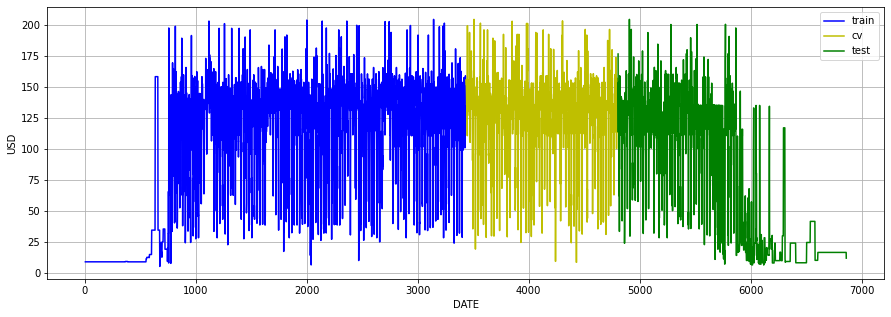

In [127]:
# График деление на train, cv, и test
plt.figure(figsize=(15, 5))
plt.plot(train.GMV, 'b',label = 'train')
plt.plot(cv.GMV, 'y',label= 'cv')
plt.plot(test.GMV, 'g',label= 'test')
plt.legend(loc='best')
plt.xlabel("DATE")
plt.ylabel("USD")
plt.grid(True)

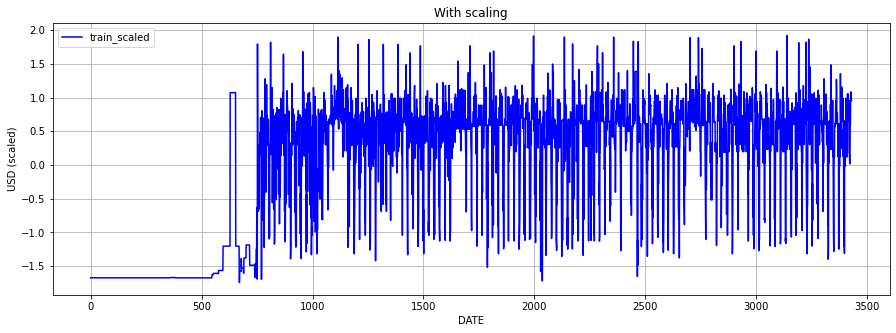

In [128]:
# Plot adjusted close over time
plt.figure(figsize=(15, 5))

plt.plot(train_scaled.GMV, 'b',label = 'train_scaled')
plt.legend(loc='best')
plt.xlabel("DATE")
plt.ylabel("USD (scaled)")
plt.title("With scaling")
plt.grid(True)

# Обучение модели с помощью XGBoost

In [129]:
# Create the model
#model = XGBRegressor(gamma=0, objective="reg:squarederror")
model = XGBRegressor()
'''model = XGBRegressor(seed = model_seed,
                     n_estimators = n_estimators,
                     max_depth = max_depth,
                     learning_rate = learning_rate,
                     min_child_weight = min_child_weight,
                     subsample = subsample,
                     colsample_bytree = colsample_bytree,
                     colsample_bylevel = colsample_bylevel,
                     gamma = gamma)'''

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Predict обучающей выборки 

In [130]:
# Do prediction on train set
pred_scaled = model.predict(X_train_scaled)
pred = pred_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

print("MAPE on train set = {:.4}".format(get_mape(y_train, pred)))
print("RMSE on train set = {:.4}".format(math.sqrt(mean_squared_error(y_train, pred))))
print("R2 on train set = {:.4}".format(r2_score(y_train, pred)))


MAPE on train set = 5.935
RMSE on train set = 8.106
R2 on train set = 0.9777


# Predict проверочной выборки

In [131]:
# Do prediction on test set
pred_scaled = model.predict(X_cv_scaled)
cv['pred_scaled'] = pred_scaled
cv['pred'] = cv['pred_scaled'] * cv['GMV_std'] + cv['GMV_mean']

print("RMSE on cv set = {:.4}".format(get_mape(y_cv, cv.pred)))
print("RMSE on cv set = {:.4}".format(math.sqrt(mean_squared_error(y_cv, cv.pred))))
print("R2 on cv set = {:.4}".format(r2_score(y_cv, cv.pred)))



RMSE on cv set = 22.49
RMSE on cv set = 28.96
R2 on cv set = -0.003826


In [132]:
# Просмотрите список функций и их оценки важности
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('MRP_lag_2', 0.012346501),
 ('range_mg_lag_3', 0.012705742),
 ('GMV_lag_2', 0.013150788),
 ('SLA_lag_2', 0.014538785),
 ('GMV_lag_3', 0.01706921),
 ('MRP_lag_3', 0.01820047),
 ('SLA_lag_1', 0.022689106),
 ('GMV_lag_1', 0.028832512),
 ('Units_lag_1', 0.03180438),
 ('MRP_lag_1', 0.77322114)]

# Final model

In [133]:
rmse, mape, r2, pred = train_pred_xgboost(X_train_cv_scaled, 
                                     y_train_cv_scaled, 
                                     X_sample_scaled, 
                                     y_sample, 
                                     test.GMV_mean,
                                     test.GMV_std)

# Calculate error
print("MAPE on test set = {:.4}".format(mape))
print("RMSE on test set = {:.4}".format(rmse))
print("R2 on test set = {:.4}".format(r2))


MAPE on test set = 23.89
RMSE on test set = 23.48
R2 on test set = 0.8212


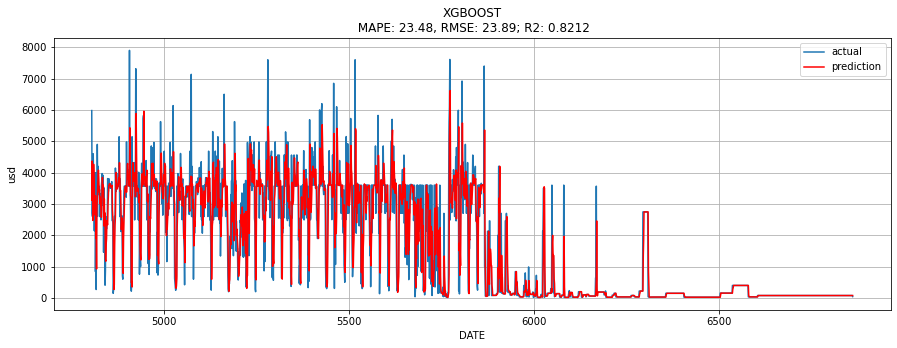

In [134]:
pred_df = pd.DataFrame({'pred': pred, 
                       'Date': df[n_train+n_cv:]['DATE']})

# График прогноза
pred_df["pred_"] = invboxcox(pred_df.pred, lmbda)

plt.figure(figsize=(15, 5))
plt.plot(test.GMV_, label="actual" )
plt.plot(pred_df.pred_,'r' ,label="prediction")
plt.legend(loc = 'best')
plt.xlabel("DATE")
plt.ylabel("usd")
#plt.xlim([1, 30])
plt.title("XGBOOST\n MAPE: {:.4}, RMSE: {:.4}; R2: {:.4}".format(
    get_mape(test.GMV, pred),
    np.sqrt(mean_squared_error(test.GMV, pred)),
    r2_score(test.GMV, pred)))
plt.grid(True)

#test.head()

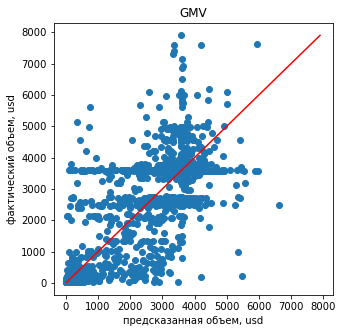

In [137]:
plt.figure(figsize=(5, 5))
plt.scatter(pred_df.pred_,test.GMV_)
plt.title("GMV")
plt.ylabel('фактический объем, usd')
plt.xlabel('предсказанная объем, usd')
plt.plot([test.GMV_.min(), test.GMV_.max()],[[test.GMV_.min()],[test.GMV_.max()]], color = 'red')

In [144]:
itog_model = pd.DataFrame({'XGBOOST': pred_df.pred_,
                          'Date': df[n_train+n_cv:]['DATE']})
#Сохранение нового файла 
itog_model.to_csv('itog_model_XGBOOST.csv', sep=';', encoding='utf-8')

In [143]:
itog_model

,XGBOOST,Date
4805,3119.687146,2016-03-17
4806,4368.361130,2016-03-17
4807,4136.423727,2016-03-17
4808,2473.699901,2016-03-17
4809,3097.597769,2016-03-17
...,...,...
6858,77.900000,2016-06-11
6859,77.900000,2016-06-11
6860,77.900000,2016-06-11
6861,77.900000,2016-06-11


In [149]:
np.array(pred)

array([125.17214904, 149.54792251, 145.30169979, ...,  16.653395  ,
        16.653395  ,  16.653395  ])